In [1]:
# !pip install deepface
from deepface import DeepFace

import matplotlib.pyplot as plt
import pandas as pd 

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

In [2]:
# Select a desired model
models = ["VGG-Face", "Facenet", "Facenet512", "OpenFace", "DeepFace", "DeepID", "ArcFace", "Dlib", "SFace"]
model_used = "ArcFace"

In [3]:
# Image selection
# FROM AFAD 
# MAN: 111, WOMAN: 112
img_path_1 = "../../../../Monash/C2001-Y3/sem1/FIT3163/others/Assignment/Project-DebFace/DebFace/datasets/AFAD/AFAD-new/33/112/1213-0.png"

# Additional data test (Kpop idols, should be harder for the model to recognize)
img_path_2 = "./additional-data/jungkook-1.jpg"
img_path_3 = "./additional-data/tzuyu-1.jpg"

1/1 [==============================] - 0s 341ms/step


{'gender': 'Woman', 'region': {'x': 0, 'y': 0, 'w': 112, 'h': 112}}

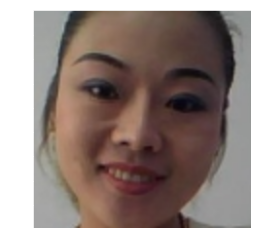

In [6]:
# Image analysis of age and gender 
image = img_path_1
obj = DeepFace.analyze(img_path = image, actions = ['gender'], enforce_detection=False)

# Image detection
img = DeepFace.detectFace(image, enforce_detection=False)
plt.imshow(img)
obj

#### Etc. 

In [19]:
import os

dir_name = "./additional-data/"
all_dir_names = os.listdir(dir_name)

# Removes previously stored representations_arcface.pkl, as adding new instances requires to re-train the model
for item in all_dir_names:
    if item.endswith(".pkl"):
        os.remove(os.path.join(dir_name, item))

In [20]:
def deepface_get_accuracy(img, model_used):
    # Recoginize all images in the dataset and verify them
    # calculate accuracy by dividing the number true image by the total number of images recognized

    # store the results of each verification:
    result = []

    try:
        # set enforce_detection to False for full body images  
        df = pd.DataFrame(DeepFace.find(img_path = img, db_path = "./additional-data", model_name = model_used, enforce_detection=False))

        # verify all the faces found
        for path in df['identity']:
            verification = DeepFace.verify(img1_path = img, img2_path = path, model_name=model_used, enforce_detection=True)
            result.append(verification["verified"])
    
    except Exception as e:
        pass

    # calculate accuracy
    acc = round(sum(result)/len(result), 2)*100        
    return f'Accuracy of {model_used} is {acc}% out of {len(result)} images'


In [21]:
deepface_get_accuracy(img_path_1, model_used)

1/1 [==============================] - 0s 121ms/step
Representations stored in  ./additional-data / representations_arcface.pkl  file. Please delete this file when you add new identities in your database.
1/1 [==============================] - 0s 121ms/step
find function lasts  8.425877809524536  seconds
1/1 [==============================] - 0s 121ms/step


'Accuracy of ArcFace is 100.0 out of 7 images%'